In [1]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
import cartopy.crs as ccrs
from cartopy.io.img_tiles import OSM
from cartopy.feature import ShapelyFeature
from matplotlib.path import Path
from matplotlib.colors import Normalize
import geopandas
from shapely.geometry import Polygon
%matplotlib inline

In [2]:
PATH_TO_DATA = '/mnt/e/python/taxi/'
LONG = [-74.25559, -73.70001]
LAT = [40.49612, 40.91553]
ESB = [40.748817, -73.985428]
LIBERTY = [40.689247, -74.044502]

In [3]:
regions = pd.read_csv(os.path.join(PATH_TO_DATA, 'regions.csv'), ';')
ring = lambda p: Polygon([(p.west, p.south), (p.west, p.north),
                          (p.east, p.north), (p.east, p.south)])
grid = geopandas.GeoDataFrame(regions.region, geometry=regions.apply(ring, axis=1))
grid.index = grid.index + 1
grid[:3]

,region,geometry
1,1,"POLYGON ((-74.25559 40.49612, -74.25559 40.504..."
2,2,"POLYGON ((-74.25559 40.50451, -74.25559 40.512..."
3,3,"POLYGON ((-74.25559 40.51290, -74.25559 40.521..."


In [7]:
grid.to_json()

'{"type": "FeatureCollection", "features": [{"id": "1", "type": "Feature", "properties": {"region": 1}, "geometry": {"type": "Polygon", "coordinates": [[[-74.25559, 40.49612], [-74.25559, 40.5045082], [-74.2444784, 40.5045082], [-74.2444784, 40.49612], [-74.25559, 40.49612]]]}}, {"id": "2", "type": "Feature", "properties": {"region": 2}, "geometry": {"type": "Polygon", "coordinates": [[[-74.25559, 40.5045082], [-74.25559, 40.5128964], [-74.2444784, 40.5128964], [-74.2444784, 40.5045082], [-74.25559, 40.5045082]]]}}, {"id": "3", "type": "Feature", "properties": {"region": 3}, "geometry": {"type": "Polygon", "coordinates": [[[-74.25559, 40.5128964], [-74.25559, 40.5212846], [-74.2444784, 40.5212846], [-74.2444784, 40.5128964], [-74.25559, 40.5128964]]]}}, {"id": "4", "type": "Feature", "properties": {"region": 4}, "geometry": {"type": "Polygon", "coordinates": [[[-74.25559, 40.5212846], [-74.25559, 40.5296728], [-74.2444784, 40.5296728], [-74.2444784, 40.5212846], [-74.25559, 40.5212846]

### 1. Загрузите агрегированные данные о поездках в мае 2016. Просуммируйте общее количество поездок такси из каждой географической зоны и посчитайте количество ячеек, из которых в мае не было совершено ни одной поездки.

In [4]:
with open(os.path.join(PATH_TO_DATA, 'pickles/yellow_tripdata_2016-05.pkl'), 'rb') as f:
    df = pickle.load(f)
df[:3]

,1,2,3,4,5,6,7,8,9,10,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
tpep_pickup_datetime,,,,,,,,,,,,,,,,,,,,,
2016-05-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-05-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-05-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 2. Нарисуйте статическую карту Нью-Йорка. Поставьте на карте точку там, где находится Эмпайр-Стейт-Билдинг.

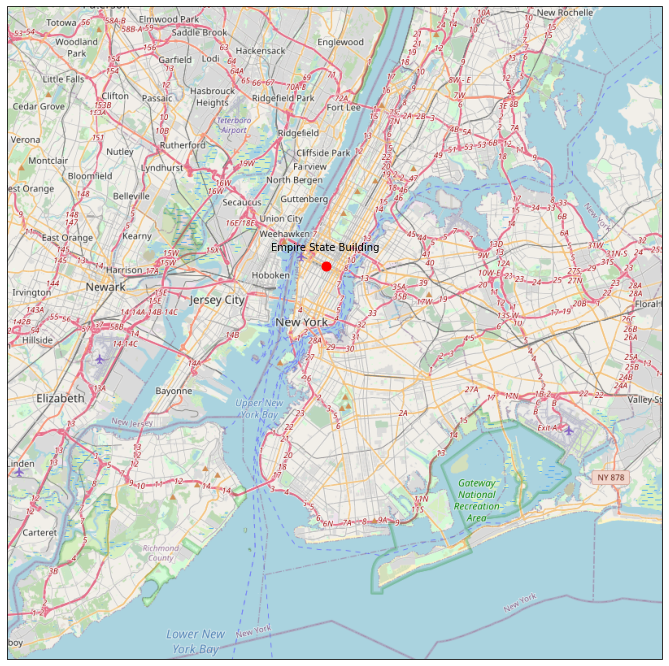

In [5]:
imagery = OSM()
crs = ccrs.PlateCarree()

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, projection=imagery.crs)
ax.set_extent([*LONG, *LAT])


# Add the imagery to the map.
ax.add_image(imagery, 11)

ax.plot(ESB[1], ESB[0], 'ro', ms=9, transform=crs)
plt.text(ESB[1], ESB[0] + 0.01, 'Empire State Building',
         horizontalalignment='center',
         transform=crs)
plt.show()

### 3. Поверх статической карты Нью-Йорка визуализируйте данные о поездках из каждой ячейки так, чтобы цветовая шкала, в которую вы окрашиваете каждую ячейку, показывала суммарное количество поездок такси из неё.

In [6]:
rides_by_zone = pd.DataFrame(df.sum(), columns = ['rides'])
rides_by_zone['region'] = df.columns
zones_0 = (rides_by_zone.rides == 0).sum()
print(f'Зон с нулевым колличеством поездок = {zones_0}')

Зон с нулевым колличеством поездок = 1283


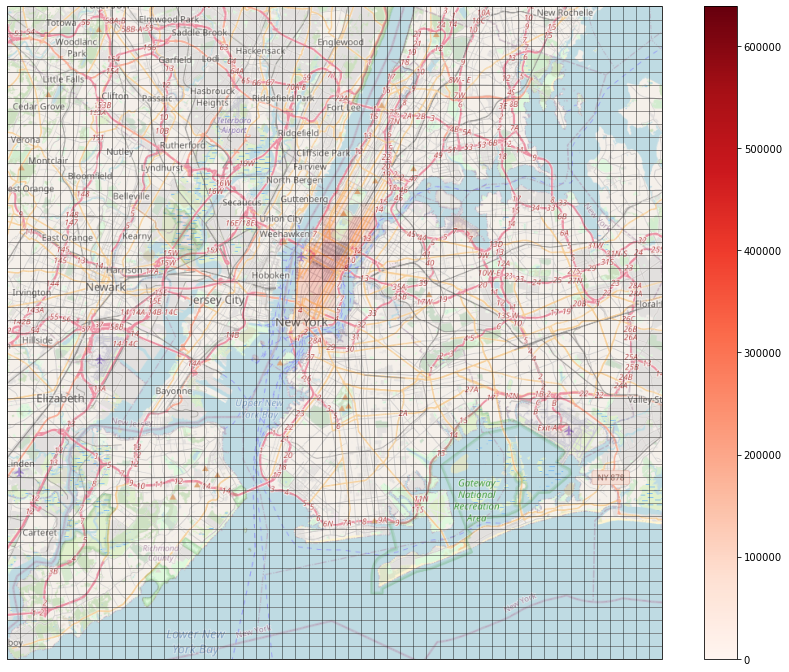

In [7]:
fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(1, 1, 1, projection=imagery.crs)
ax.set_extent([*LONG, *LAT], crs)


# Add the imagery to the map.
ax.add_image(imagery, 11)


norm = Normalize(vmin=min(rides_by_zone.rides), vmax=max(rides_by_zone.rides))
cmap = plt.cm.get_cmap('Reds')
for c, v in zip(grid.geometry, rides_by_zone.rides):
    sp = ShapelyFeature([c], crs, edgecolor='k', alpha=0.25, facecolor=cmap(norm(v)))
    ax.add_feature(sp)


sm = plt.cm.ScalarMappable(cmap=cmap,norm=norm)
sm._A = []
plt.colorbar(sm)

plt.show()

### 4. Вставьте интерактивную карту Нью-Йорка — такую, которую можно прокручивать и увеличивать. Поставьте метку там, где находится статуя свободы.

In [8]:
m = folium.Map(location=[np.mean(LAT), np.mean(LONG)])
m.fit_bounds(list(zip(LAT, LONG)))
#m.fit_bounds([LAT[0], LONG[0]], [LAT[1], LONG[1]])
folium.Marker(
    location=LIBERTY,
    popup="The Statue of Liberty National Monument",
    icon=folium.Icon(color="red", icon="info-sign"),
).add_to(m)
m

### 5. Нарисуйте на интерактивной карте Нью-Йорка ячейки так, чтобы их цвет показывал среднее за месяц количество поездок такси в час из этой зоны.

In [9]:
rides_per_hour = pd.DataFrame(df.mean(), columns = ['rides'])
rides_per_hour['region'] = df.columns
rides_per_hour.rides.agg(['max', 'mean'])

max     858.600806
mean      6.250818
Name: rides, dtype: float64

In [10]:
m = folium.Map(location=[np.mean(LAT), np.mean(LONG)], zoom_start=11)
#m.fit_bounds(list(zip(LAT, LONG)))

folium.Choropleth(
    geo_data=grid.to_json(),
    name='choropleth',
    data=rides_per_hour,
    columns=['region', 'rides'],
    key_on='feature.properties.region',
    fill_color='RdPu',
    fill_opacity=0.4,
    line_opacity=0.2,
    bins=7,
    legend_name='Total rides'
).add_to(m)


m

### 6. Oтфильтруйте ячейки, из которых в мае совершается в среднем меньше 5 поездок в час. Посчитайте количество оставшихся. Проверьте на карте, что среди этих ячеек нет таких, из которых поездки на самом деле невозможны.

In [11]:
rides_more5_per_hour = rides_per_hour[rides_per_hour.rides>=5]
print(f'Колличество зон из которых совершается в среднем больше 5 поездок в час = {rides_more5_per_hour.shape[0]}')

Колличество зон из которых совершается в среднем больше 5 поездок в час = 102


In [73]:
grid_more5_per_hour = grid.loc[rides_more5_per_hour.index]

In [76]:
y1, x1, y2, x2 = grid_more5_per_hour.bounds.agg({'minx': 'min', 'miny': 'min', 'maxx': 'max', 'maxy': 'max'}).to_list()

In [78]:
# Отобразим отобранные ячейки на карте.
m = folium.Map()
m.fit_bounds([[x1, y1], [x2, y2]])
folium.GeoJson(grid_more5_per_hour.to_json()).add_to(m)

# Добавим номер ячейки во всплывающем окне
style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}


zoneName = folium.features.GeoJson(
    grid_more5_per_hour.to_json(),
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['region'],
        aliases=['Регион №'],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
)
m.add_child(zoneName)
m.keep_in_front(zoneName)


# Adding folium layer to the map
folium.LayerControl().add_to(m)

m

#### На карте видим наличие некоторых ячеек, практически полностью рассположенных на реке. 

In [123]:
grid_more5_per_hour

,region,geometry
1075,1075,"POLYGON ((-74.02225 40.69744, -74.02225 40.705..."
1076,1076,"POLYGON ((-74.02225 40.70582, -74.02225 40.714..."
1077,1077,"POLYGON ((-74.02225 40.71421, -74.02225 40.722..."
1125,1125,"POLYGON ((-74.01113 40.69744, -74.01113 40.705..."
1126,1126,"POLYGON ((-74.01113 40.70582, -74.01113 40.714..."
...,...,...
2068,2068,"POLYGON ((-73.80001 40.63872, -73.80001 40.647..."
2069,2069,"POLYGON ((-73.80001 40.64711, -73.80001 40.655..."
2118,2118,"POLYGON ((-73.78890 40.63872, -73.78890 40.647..."
2119,2119,"POLYGON ((-73.78890 40.64711, -73.78890 40.655..."


In [125]:
with open(PATH_TO_DATA + 'selected_regions.pkl', 'wb') as f:
    pickle.dump(grid_more5_per_hour.region, f)